In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
train = pd.read_csv("clean_train_reviewsbg.csv")

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [4]:
def make_xy(critics, vectorizer=None): 
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train.cleanReview)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (train.sentiment == 1).values.astype(np.int)
    return X, y
X, y = make_xy(train)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.33, random_state=42)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

from sklearn.metrics import accuracy_score

print('accuracy scores training set: ',accuracy_score(y_train,y_pred_train))
print('accuracy scores test set: ',accuracy_score(y_test,y_pred_test))

print(y.mean())

accuracy scores training set:  0.9238805970149254
accuracy scores test set:  0.864
0.5


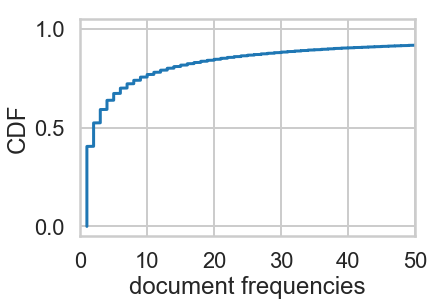

In [6]:
import numpy as np

#calculating df
df = np.sum(X>0,axis=0)

#making the CDF plot
sort_df = np.sort(df).reshape(-1,1)

y_values=np.arange(len(sort_df))/float(len(sort_df)-1)

plt.plot(sort_df,y_values)
plt.xlim([0,50])
plt.xlabel('document frequencies')
plt.ylabel('CDF')

plt.show()

In [7]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [8]:

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [9]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(train.shape[0]), train_size=0.66)
mask = np.zeros(train.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\ngmat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 2

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(train, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clf = MultinomialNB(alpha=alpha)
    score_t = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    if score_t > maxscore:
        maxscore = score_t
        best_alpha = alpha

In [11]:
print("alpha: {}".format(best_alpha))

alpha: 50


In [11]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(train, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.876353
Accuracy on test data:     0.853333


In [12]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_curve, auc, roc_auc_score
print(confusion_matrix(ytest, clf.predict(xtest)))

[[7152 1114]
 [1306 6928]]


In [13]:
print(classification_report(ytest, clf.predict(xtest)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      8266
           1       0.86      0.84      0.85      8234

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.85      0.85      0.85     16500
weighted avg       0.85      0.85      0.85     16500



In [15]:
sen_pred_test_roc = clf.predict_proba(xtest)
sen_pred_test_roc_positive = sen_pred_test_roc[:, 1]

In [17]:
auc = roc_auc_score(ytest, sen_pred_test_roc_positive)
print('AUC: %.2f' % auc)

AUC: 0.92


In [18]:
fpr, tpr, thresholds = roc_curve(ytest, sen_pred_test_roc_positive)

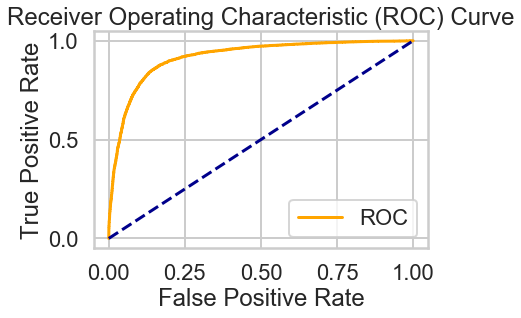

In [19]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()